In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage[utf8]{inputenc}\usepackage[T1]{fontenc}\usepackage{lmodern}"
})

## Przypadek dla macierzy kowariancji z $\mu = 0,5$.
### Definiujemy stopień rzadkości jako 10% wektora regresji

In [27]:
# Parametry
d_wartosci = [128, 256, 512]
liczba_prob = 100
mu = 0.5
s = lambda d: int(0.1 * d)

In [ ]:
def generuj_macierz_kowariancji(d, mu):
    """
    Tworzy macierz kowariancji Σ = (1 - μ)I + μ 1 1^T dla danego d i μ.
    """
    I = np.eye(d)  # Macierz jednostkowa (d x d)
    J = np.ones((d, d))  # Macierz wypełniona jedynkami (d x d)
    return (1 - mu) * I + mu * J

def generuj_losowa_macierz(d, n, mu):
    """
    Generuje macierz X o wymiarach (n, d), gdzie każdy wiersz jest losowany
    z wielowymiarowego rozkładu normalnego N(0, Σ), z Σ = (1 - μ)I + μ 1 1^T.
    """
    Sigma = generuj_macierz_kowariancji(d, mu)  # Macierz kowariancji
    X = np.random.multivariate_normal(np.zeros(d), Sigma, size=n)  # Generowanie wierszy
    return X

# Generowanie rzadkiego sygnału o d wymiarach i s niezerowych elementach
def rzadki_sygnal(d, s):
    theta = np.zeros(d)
    niezerowe_indeksy = np.random.choice(d, s, replace=False)
    theta[niezerowe_indeksy] = np.random.randn(s)
    return theta

# Rozwiązywanie problemu metodą programowania liniowego
def basis_pursuit(X, y):
    d = X.shape[1]  # Liczba kolumn macierzy X (wymiar przestrzeni sygnału)
    c = np.ones(2 * d)  # Wektor celu (minimalizacja sumy modułów zmiennych)
    
    # Tworzenie macierzy
    X_eq = np.hstack((X, -X))
    y_eq = y
    
    # Ograniczenia dla zmiennych (muszą być nieujemne) jak w pracy
    ograniczenia = [(0, None) for _ in range(2 * d)]
    
    # Rozwiązywanie problemu programowania liniowego
    res = linprog(c, A_eq=X_eq, b_eq=y_eq, bounds=ograniczenia, method='highs')
    
    # Odtworzenie sygnału jako różnicy zmiennych pomocniczych
    theta_odtworzony = res.x[:d] - res.x[d:]
    return theta_odtworzony

# Przeprowadzanie eksperymentu sprawdzającego skuteczność odzyskiwania sygnału
def wykonaj_eksperyment(d, s, n, mu):
    X = generuj_losowa_macierz(d, n, mu)  # Generowanie losowej macierzy
    theta = rzadki_sygnal(d, s)  # Generowanie rzadkiego sygnału
    y = X @ theta  # Obliczenie obserwacji
    theta_odtworzony = basis_pursuit(X, y)  # Próba odzyskania sygnału
    
    # Sprawdzenie, czy odtworzony sygnał jest bliski oryginalnemu
    sukces = np.linalg.norm(theta - theta_odtworzony) < 1e-8
    #sukces = theta== theta_odtworzony  # Sprawdzenie równości sygnałów
    return sukces

# Obliczanie prawdopodobieństwa poprawnego odzyskania sygnału dla różnych n
def prawdopodobienstwo_odzyskania(d, s, n_wartosci, mu, liczba_prob):
    prawdopodobienstwa = []
    for n in n_wartosci:
        sukcesy = [wykonaj_eksperyment(d, s, n, mu) for _ in range(liczba_prob)]
        prawdopodobienstwa.append(np.mean(sukcesy))  # Średnia liczba sukcesów - frakcja sukcesów
    return prawdopodobienstwa

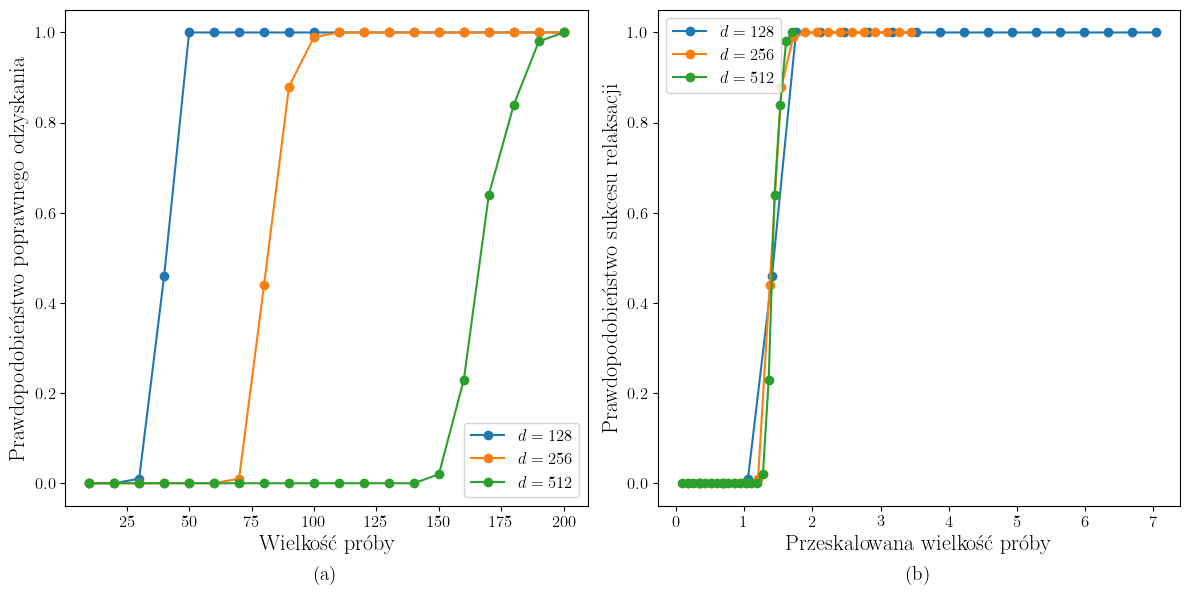

0.5


In [29]:
# Generowanie wartości n w zakresie od 10 do 200 z krokiem 10
n_wartosci = np.arange(10, 201, 10)

# Przeskalowanie wartości n dla różnych d
przeskalowane_n_wartosci = {d: n_wartosci / (s(d) * np.log(d / s(d))) for d in d_wartosci}

# Obliczenie prawdopodobieństwa poprawnego odzyskania sygnału
prawdopodobienstwa = {d: prawdopodobienstwo_odzyskania(d, s(d), n_wartosci, mu, liczba_prob) for d in d_wartosci}

# Tworzenie wykresów
fig, osie = plt.subplots(1, 2, figsize=(12, 6))

# Wykres (a): Prawdopodobieństwo odzyskania vs. rozmiar próby
for d in d_wartosci:
    osie[0].plot(n_wartosci, prawdopodobienstwa[d], label=fr'$d = {d}$', marker='o')
osie[0].set_xlabel(r'Wielkość próby', fontsize=16)
osie[0].set_ylabel(r'Prawdopodobieństwo poprawnego odzyskania', fontsize=16)
osie[0].tick_params(axis='both', labelsize=12)  # <-- Zwiększenie wielkości liczb na osiach
osie[0].legend(fontsize=12)
osie[0].text(0.5, -0.15, '(a)', transform=osie[0].transAxes, fontsize=14, ha='center')


# Wykres (b): Prawdopodobieństwo odzyskania vs. przeskalowany rozmiar próby
for d in d_wartosci:
    osie[1].plot(przeskalowane_n_wartosci[d], prawdopodobienstwa[d], label=fr'$d = {d}$', marker='o')
osie[1].set_xlabel(r'Przeskalowana wielkość próby', fontsize=16)
osie[1].set_ylabel(r'Prawdopodobieństwo sukcesu relaksacji', fontsize=16)
osie[1].tick_params(axis='both', labelsize=12)  # <-- Zwiększenie wielkości liczb na osiach
osie[1].legend(fontsize=12)
osie[1].text(0.5, -0.15, '(b)', transform=osie[1].transAxes, fontsize=14, ha='center')



plt.tight_layout()
plt.show()
print(mu)

In [30]:
fig.savefig("zdjecia_symulacji/sukces_relaksacji_symulacja_mu05.svg", format="svg", bbox_inches="tight", pad_inches=0.1)

## Przypadek dla macierzy kowariancji z $\mu = 0$.

In [31]:
mu=0

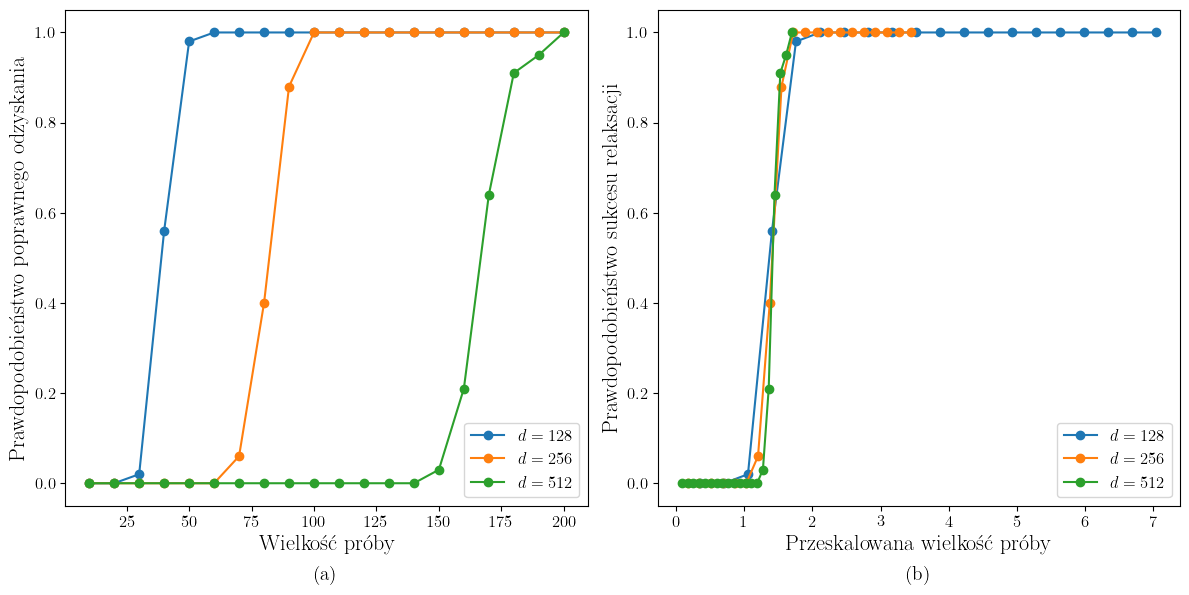

0


In [33]:
# Generowanie wartości n w zakresie od 10 do 200 z krokiem 10
n_wartosci = np.arange(10, 201, 10)

# Przeskalowanie wartości n dla różnych d
przeskalowane_n_wartosci = {d: n_wartosci / (s(d) * np.log(d / s(d))) for d in d_wartosci}

# Obliczenie prawdopodobieństwa poprawnego odzyskania sygnału
prawdopodobienstwa = {d: prawdopodobienstwo_odzyskania(d, s(d), n_wartosci, mu, liczba_prob) for d in d_wartosci}

# Tworzenie wykresów
fig, osie = plt.subplots(1, 2, figsize=(12, 6))

# Wykres (a): Prawdopodobieństwo odzyskania vs. rozmiar próby
for d in d_wartosci:
    osie[0].plot(n_wartosci, prawdopodobienstwa[d], label=fr'$d = {d}$', marker='o')
osie[0].set_xlabel(r'Wielkość próby', fontsize=16)
osie[0].set_ylabel(r'Prawdopodobieństwo poprawnego odzyskania', fontsize=16)
osie[0].tick_params(axis='both', labelsize=12)
osie[0].legend(fontsize=12)
osie[0].text(0.5, -0.15, '(a)', transform=osie[0].transAxes, fontsize=14, ha='center')

# Wykres (b): Prawdopodobieństwo odzyskania vs. przeskalowany rozmiar próby
for d in d_wartosci:
    osie[1].plot(przeskalowane_n_wartosci[d], prawdopodobienstwa[d], label=fr'$d = {d}$', marker='o')
osie[1].set_xlabel(r'Przeskalowana wielkość próby', fontsize=16)
osie[1].set_ylabel(r'Prawdopodobieństwo sukcesu relaksacji', fontsize=16)
osie[1].tick_params(axis='both', labelsize=12)
osie[1].legend(fontsize=12)
osie[1].text(0.5, -0.15, '(b)', transform=osie[1].transAxes, fontsize=14, ha='center')

plt.tight_layout()
plt.show()

print(mu)

In [34]:
fig.savefig("zdjecia_symulacji/sukces_relaksacji_symulacja_mu0.svg", format="svg", bbox_inches="tight", pad_inches=0.1)